In [1]:
import os
import gc
import random

import numpy as np

import rasterio

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from typing import Callable, Dict, Optional, Tuple

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch import Tensor

from torchgeo.datasets import (RasterDataset, 
                               stack_samples, 
                               splits, 
                               random_bbox_splitting)

from torchgeo.samplers import RandomGeoSampler, GridGeoSampler
from torchgeo.trainers import SemanticSegmentationTask

from torchinfo import summary
from torchmetrics.classification import MulticlassF1Score, MulticlassJaccardIndex

from skimage.util import view_as_windows

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import FocalLoss

from pprint import pprint

from tqdm.auto import tqdm, trange

import warnings
warnings.simplefilter('ignore')

%config InlineBackend.figure_format = 'retina'

In [2]:
config = {
    'seed': 2024,
    'batch_size': 128,
    'epochs': 100,
    'optimizer': 'Adam',
    'learning_rate': 1e-3,
    'num_classes': 3,    
    'ignore_index': 2,
    'in_channels': 4, 
    'model': 'DeepLabV3Plus',
    'encoder_name': 'efficientnet-b0',
    'trial': 1,
    'size': (224, 224),
    'length': 5_000,
    'patience': 10,
    'T_0': 10,
    # 'gamma': 3.0,
}

In [3]:
# https://pytorch.org/docs/stable/notes/randomness.html
def seed_everything(seed: int) -> None:
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.use_deterministic_algorithms(mode=True)
    torch.backends.cudnn.benchmark = True

seed_everything(config['seed'])

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Loading data

In [5]:
def load_tif_image(patch: str) -> Tuple[np.array, list]:
    with rasterio.open(patch, mode='r') as src:
        arr = src.read()
        img = np.moveaxis(arr, 0, -1)
        profile = src.profile

    return img, profile

In [7]:
class SARImages(RasterDataset):

    filename_glob = '*.tif'
    is_image = True
    separate_files = False
    all_bands = ['VV', 'VH']

In [8]:
class SARLabels(RasterDataset):

    filename_glob = '*.tif'
    is_image = False
    all_bands = [0]

In [9]:
# Load SAR images
img_2018 = SARImages('./data/18210.tif')
img_2019 = SARImages('./data/19229.tif')
img_2020 = SARImages('./data/20218.tif')

# Load labels
train_label = SARLabels('./data/label_2019.tif')
test_label  = SARLabels('./data/label_2020.tif')

In [10]:
dataset  = img_2018 & img_2019 & train_label  # dimensions: [H, W, 5]
test_data = img_2019 & img_2020 & test_label

### Preparing data to feed the model

In [11]:
# Split data into 70 % for training and 20 % for validation
generator = torch.Generator().manual_seed(config['seed'])
train_data, valid_data, _ = random_bbox_splitting(dataset, fractions=[0.7, 0.2, 0.1], generator=generator)

In [12]:
# Prepare dataloaders
train_sampler = RandomGeoSampler(train_data, size=config['size'], length=config['length'])
trainloader = DataLoader(train_data, batch_size=config['batch_size'], sampler=train_sampler, collate_fn=stack_samples)

valid_sampler = RandomGeoSampler(valid_data, size=config['size'], length=config['length'])
validloader = DataLoader(valid_data, batch_size=config['batch_size'], sampler=valid_sampler, collate_fn=stack_samples)

test_sampler = GridGeoSampler(test_data, size=config['size'], stride=config['size'])
testloader = DataLoader(test_data, batch_size=config['batch_size'], sampler=test_sampler, collate_fn=stack_samples)

In [13]:
# Sanity check
sample = next(iter(trainloader))

sample['image'].shape, sample['mask'].shape

(torch.Size([128, 4, 224, 224]), torch.Size([128, 1, 224, 224]))

### Model architecture

In [14]:
model = getattr(smp, config['model'])(
    encoder_name=config['encoder_name'],    
    encoder_weights='imagenet',             
    in_channels=config['in_channels'],
    classes=config['num_classes'],          
)

In [15]:
print(summary(model, 
              (config['batch_size'], 4, 224, 224),
              col_names=['input_size', 'num_params', 'trainable'],
              device='cpu'))

Layer (type:depth-idx)                                  Input Shape               Param #                   Trainable
DeepLabV3Plus                                           [128, 4, 224, 224]        --                        True
├─EfficientNetEncoder: 1-1                              [128, 4, 224, 224]        412,160                   True
│    └─Conv2dStaticSamePadding: 2-1                     [128, 4, 224, 224]        1,152                     True
│    │    └─ZeroPad2d: 3-1                              [128, 4, 224, 224]        --                        --
│    └─BatchNorm2d: 2-2                                 [128, 32, 112, 112]       64                        True
│    └─MemoryEfficientSwish: 2-3                        [128, 32, 112, 112]       --                        --
│    └─ModuleList: 2-4                                  --                        --                        True
│    │    └─MBConvBlock: 3-2                            [128, 32, 112, 112]       1,448        

In [16]:
def train_fn(model, dataloader, optimizer, criterion, epoch):

    scaler = torch.cuda.amp.GradScaler()       # deal with out of memory    
    
    model.train()
    
    metric = MulticlassF1Score(num_classes=config['num_classes'], 
                               average='macro',
                               ignore_index=config['ignore_index']).to(device=device)
    
    running_loss = 0.0  
    for ii, sample in enumerate(tqdm(dataloader, leave=False)):
        images = sample['image'].to(device)
        labels = sample['mask'].squeeze().to(device)

        
        optimizer.zero_grad(set_to_none=True)  # set gradients to zero
        
        # Forward pass
        with torch.cuda.amp.autocast():        # autocasting
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        # Backward pass
        scaler.scale(loss).backward() 
        scaler.step(optimizer)
        scaler.update()

        # Set up scheduler
        scheduler.step(epoch + ii / len(dataloader))
        
        # Compute metrics
        running_loss += loss.item()
        metric.update(outputs, labels)
        
        # Release memory
        torch.cuda.empty_cache()
        _ = gc.collect()
        
    f1_macro = metric.compute()
    metric.reset()
    
    return running_loss / len(dataloader), f1_macro

In [17]:
@torch.no_grad()
def valid_fn(model, dataloader, criterion):
    
    model.eval() 
    
    metric = MulticlassF1Score(num_classes=config['num_classes'], 
                               average='macro',
                               ignore_index=config['ignore_index']).to(device=device)
    
    running_loss = 0.0

    for sample in tqdm(dataloader, leave=False):
        images = sample['image'].to(device)
        labels = sample['mask'].squeeze().to(device)
        
        with torch.cuda.amp.autocast():  # autocasting
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Compute metrics
        running_loss += loss.item()
        metric.update(outputs, labels)
        
        # Release memory
        torch.cuda.empty_cache()
        _ = gc.collect()
    
    f1_macro = metric.compute()
    metric.reset()

    return running_loss / len(dataloader), f1_macro

In [18]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.valid_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, valid_loss, model):

        score = -valid_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(valid_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(valid_loss, model)
            self.counter = 0

    def save_checkpoint(self, valid_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.valid_loss_min = valid_loss

In [19]:
model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=config['ignore_index'])
# criterion = FocalLoss(mode='multiclass', gamma=config['gamma'], ignore_index=config['ignore_index'])
optimizer = getattr(optim, config['optimizer'])(model.parameters(), lr=config['learning_rate'])

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=config['T_0'])

### Training and evaluanting the model

In [20]:
%%time

history = {
    'valid_loss': [],
    'train_loss': [],
    'train_f1': [],
    'valid_f1': [],
}

# initialize the early_stopping object
checkpoint = f"./models/{config['encoder_name']}_{config['trial']}.pt"
early_stopping = EarlyStopping(patience=config['patience'], verbose=True, path=checkpoint)

for epoch in (pbar := trange(config['epochs'])):
        
    train_loss, train_f1 = train_fn(model, trainloader, optimizer, criterion, epoch)
    valid_loss, valid_f1 = valid_fn(model, validloader, criterion)

            
    print(f'Epoch {epoch + 1:>03}/{config["epochs"]} | ',
          f'Train loss: {train_loss:8.5f} | Train f1 macro: {train_f1:8.5f} | ', 
          f'Valid loss: {valid_loss:8.5f} | Valid f1 macro: {valid_f1:8.5f}')
    
    # early_stopping needs the validation loss to check if it has decresed,
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_loss, model)

    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['train_f1'].append(train_f1.item())
    history['valid_f1'].append(valid_f1.item())

    if early_stopping.early_stop:
        print("Early stopping")
        break


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 001/100 |  Train loss:  0.17594 | Train f1 macro:  0.39797 |  Valid loss:  0.58879 | Valid f1 macro:  0.44239
Validation loss decreased (inf --> 0.588789).  Saving model ...


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 002/100 |  Train loss:  0.02850 | Train f1 macro:  0.81617 |  Valid loss:  0.14775 | Valid f1 macro:  0.54634
Validation loss decreased (0.588789 --> 0.147749).  Saving model ...


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 003/100 |  Train loss:  0.01755 | Train f1 macro:  0.88237 |  Valid loss:  0.09724 | Valid f1 macro:  0.50129
Validation loss decreased (0.147749 --> 0.097235).  Saving model ...


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 004/100 |  Train loss:  0.01398 | Train f1 macro:  0.88861 |  Valid loss:  0.07211 | Valid f1 macro:  0.58157
Validation loss decreased (0.097235 --> 0.072108).  Saving model ...


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 005/100 |  Train loss:  0.01175 | Train f1 macro:  0.91761 |  Valid loss:  0.04056 | Valid f1 macro:  0.76934
Validation loss decreased (0.072108 --> 0.040560).  Saving model ...


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 006/100 |  Train loss:  0.01028 | Train f1 macro:  0.92308 |  Valid loss:  0.03757 | Valid f1 macro:  0.80431
Validation loss decreased (0.040560 --> 0.037570).  Saving model ...


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 007/100 |  Train loss:  0.00998 | Train f1 macro:  0.92860 |  Valid loss:  0.02551 | Valid f1 macro:  0.86269
Validation loss decreased (0.037570 --> 0.025511).  Saving model ...


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 008/100 |  Train loss:  0.00936 | Train f1 macro:  0.93595 |  Valid loss:  0.02555 | Valid f1 macro:  0.87582
EarlyStopping counter: 1 out of 10


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 009/100 |  Train loss:  0.00900 | Train f1 macro:  0.93673 |  Valid loss:  0.02339 | Valid f1 macro:  0.88483
Validation loss decreased (0.025511 --> 0.023387).  Saving model ...


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 010/100 |  Train loss:  0.00879 | Train f1 macro:  0.93648 |  Valid loss:  0.01786 | Valid f1 macro:  0.90216
Validation loss decreased (0.023387 --> 0.017861).  Saving model ...


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 011/100 |  Train loss:  0.00919 | Train f1 macro:  0.92332 |  Valid loss:  0.01484 | Valid f1 macro:  0.91896
Validation loss decreased (0.017861 --> 0.014839).  Saving model ...


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 012/100 |  Train loss:  0.00878 | Train f1 macro:  0.94042 |  Valid loss:  0.01525 | Valid f1 macro:  0.91625
EarlyStopping counter: 1 out of 10


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 013/100 |  Train loss:  0.01052 | Train f1 macro:  0.91974 |  Valid loss:  0.03198 | Valid f1 macro:  0.82038
EarlyStopping counter: 2 out of 10


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 014/100 |  Train loss:  0.00687 | Train f1 macro:  0.94488 |  Valid loss:  0.02094 | Valid f1 macro:  0.88258
EarlyStopping counter: 3 out of 10


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 015/100 |  Train loss:  0.00600 | Train f1 macro:  0.94924 |  Valid loss:  0.02942 | Valid f1 macro:  0.85715
EarlyStopping counter: 4 out of 10


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 016/100 |  Train loss:  0.00604 | Train f1 macro:  0.95746 |  Valid loss:  0.01799 | Valid f1 macro:  0.91117
EarlyStopping counter: 5 out of 10


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 017/100 |  Train loss:  0.00551 | Train f1 macro:  0.95576 |  Valid loss:  0.02722 | Valid f1 macro:  0.86461
EarlyStopping counter: 6 out of 10


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 018/100 |  Train loss:  0.00559 | Train f1 macro:  0.95891 |  Valid loss:  0.02531 | Valid f1 macro:  0.87933
EarlyStopping counter: 7 out of 10


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 019/100 |  Train loss:  0.00470 | Train f1 macro:  0.96239 |  Valid loss:  0.02105 | Valid f1 macro:  0.89904
EarlyStopping counter: 8 out of 10


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 020/100 |  Train loss:  0.00527 | Train f1 macro:  0.96220 |  Valid loss:  0.01791 | Valid f1 macro:  0.91295
EarlyStopping counter: 9 out of 10


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 021/100 |  Train loss:  0.00491 | Train f1 macro:  0.95976 |  Valid loss:  0.01960 | Valid f1 macro:  0.90484
EarlyStopping counter: 10 out of 10
Early stopping
CPU times: user 15h 13min 5s, sys: 14min 23s, total: 15h 27min 29s
Wall time: 1h 57min 9s


### Training and validation metrics evolution

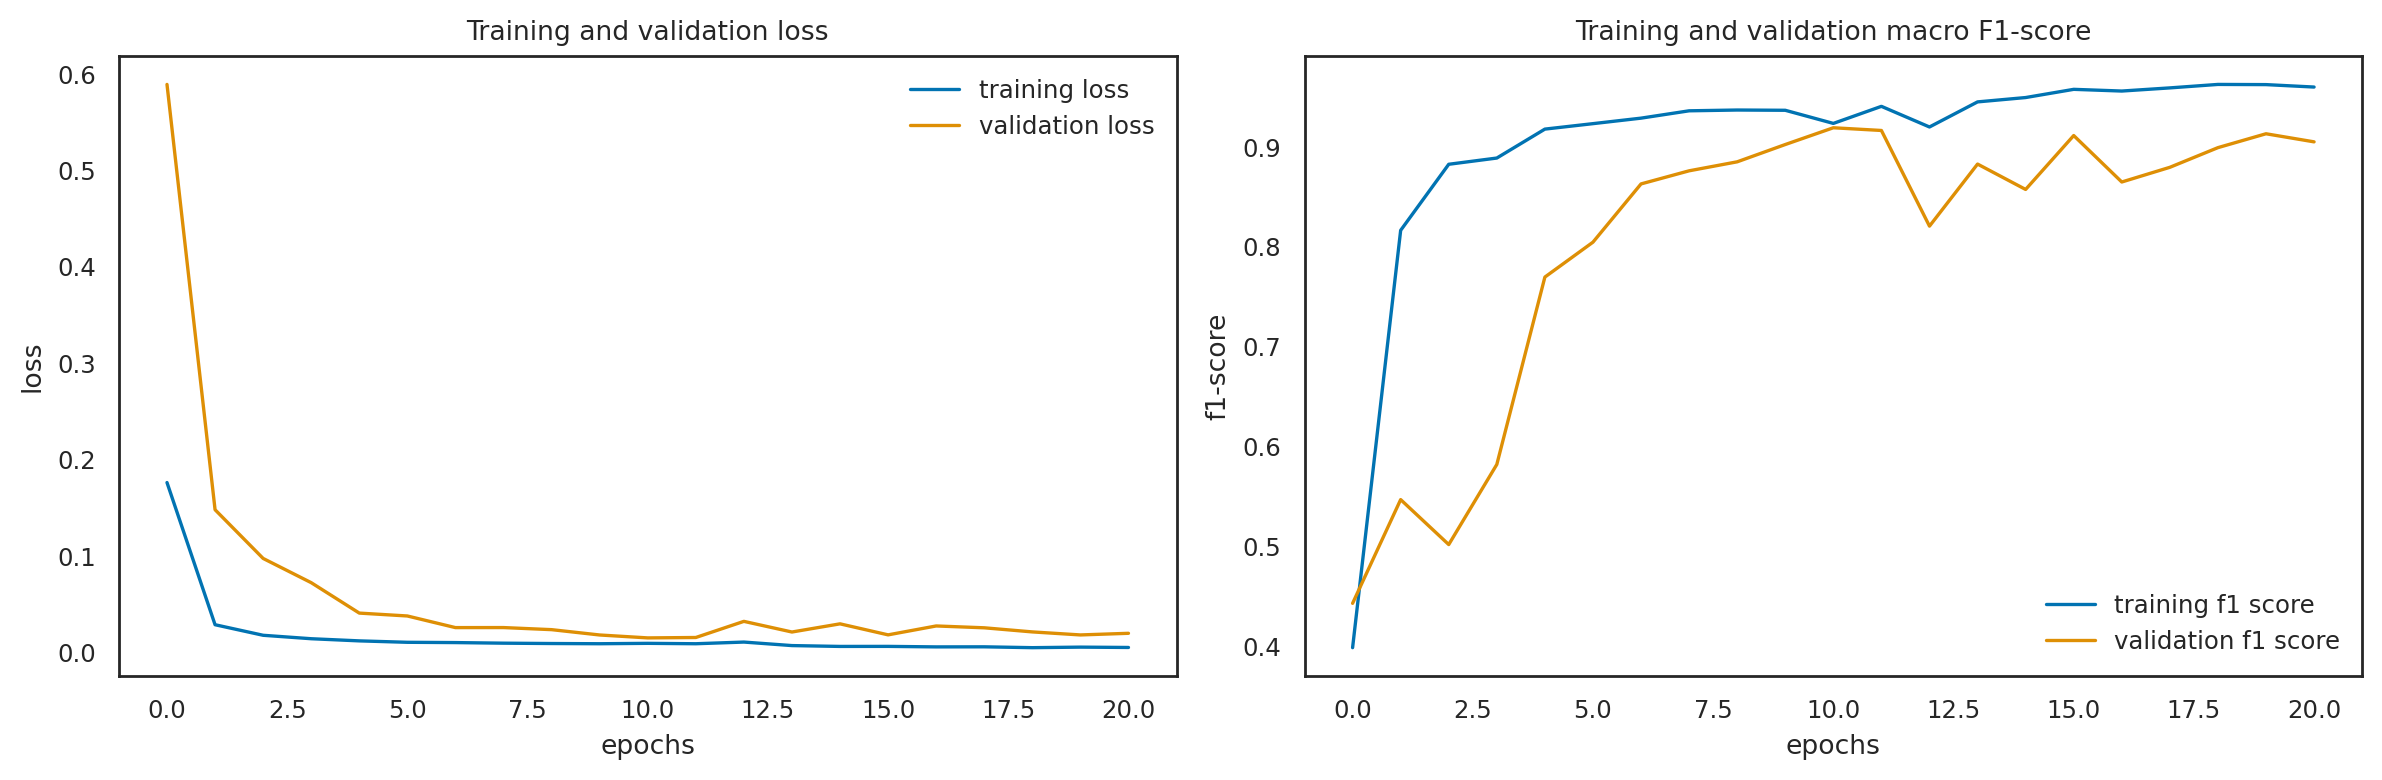

In [21]:
sns.set(context='paper', style='white', palette='colorblind')

fig, ax = plt.subplots(1, 2, figsize=[12, 4], layout='constrained')

sns.lineplot(history['train_loss'], label='training loss', ax=ax[0])
sns.lineplot(history['valid_loss'], label='validation loss', ax=ax[0])
ax[0].set(xlabel='epochs', ylabel='loss', title='Training and validation loss')
sns.move_legend(ax[0], loc='best', frameon=False)

sns.lineplot(history['train_f1'], label='training f1 score', ax=ax[1])
sns.lineplot(history['valid_f1'], label='validation f1 score', ax=ax[1])
ax[1].set(xlabel='epochs', ylabel='f1-score', title='Training and validation macro F1-score')
sns.move_legend(ax[1], loc='best', frameon=False)

plt.tight_layout();

plt.savefig(f"./assets/{config['encoder_name']}_{config['trial']}.png", dpi=300)

In [22]:
# Load the last checkpoint with the best model
model.load_state_dict(torch.load(checkpoint))

<All keys matched successfully>

### Predictions

In [23]:
@torch.no_grad()
def eval_fn(model, dataloader):
    
    model.eval() 
    
    metric = MulticlassF1Score(num_classes=config['num_classes'], 
                               average='macro',
                               ignore_index=config['ignore_index']).to(device=device)
    
    jaccard_metric = MulticlassJaccardIndex(num_classes=config['num_classes'],
                                            average='macro',
                                            ignore_index=config['ignore_index']).to(device=device)

    y_true, y_pred = (torch.tensor([], device=device), torch.tensor([], device=device))
    

    running_loss = 0.0
    for sample in tqdm(dataloader):
        images = sample['image'].to(device)
        labels = sample['mask'].squeeze().to(device) # , dtype=torch.long)
        
        with torch.cuda.amp.autocast():  # autocasting
            outputs = model(images)

        # Compute metrics
        metric.update(outputs, labels)
        jaccard_metric.update(outputs, labels)
       
        # Garbage collection
        torch.cuda.empty_cache()
        _ = gc.collect()
        
    f1_macro = metric.compute()
    metric.reset()

    IoU = jaccard_metric.compute()
    jaccard_metric.reset()

    print(f'Test f1-score macro: {f1_macro:.5f}')
    print(f'Test IoU macro: {IoU:.5f}')


In [24]:
eval_fn(model, testloader)

  0%|          | 0/20 [00:00<?, ?it/s]

Test f1-score macro: 0.89236
Test IoU macro: 0.82216
